In [11]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

eps = np.finfo(float).eps

def drawPerspective(handleax,input_matrix,title=None,cmap = "gray"):
    handleax.set_title(title)
    handleax.set_zlabel('Z')  # 坐标轴
    handleax.set_ylabel('Y')
    handleax.set_xlabel('X')
    x,y = input_matrix.shape
    X = np.arange(0,x,1)
    Y = np.arange(0,y,1)
    # 由于图像x,y坐标和 meshigrid出来是互反的
    # 这里需要调转一下
    # 否则会出现mismatch的现象
    X,Y = np.meshgrid(Y, X)
    handleax.plot_surface(Y, X, input_matrix, cmap=cmap)
#     handleax.plot_wireframe(Y, X, input_matrix, cmap=cmap)

def drawPanel(handleax,input_matrix,title=None,cmap = "gray"):
    handleax.set_title(title)
    handleax.set_ylabel('Y')
    handleax.set_xlabel('X')
    handleax.imshow(input_matrix,cmap = cmap)

def drawCurv(handleax,functions,labels,filter_d0,title=None,cmap = "gray"):
    # 绘制从0到 3D_0的函数剖面图
    handleax.set_title(title)
    handleax.set_xlabel("$D(u,v)$")
    handleax.set_ylabel("$H(u,v)$")
    # 标出D_0点
    # handleax.annotate(r"$D_0$", xy = (filter_d0,0) , weight='heavy')
    
    for func,lab in zip(functions,labels):
        # 对每一对func和label绘图 （针对需要画多条线的情况）
        X = np.arange(0,3*filter_d0+1,0.1)
        Y = func(X)
        handleax.plot(X,Y,label = lab)
    handleax.set_xticks([0,filter_d0])
    handleax.set_xticklabels(["$0$","$D_0$"])
    handleax.legend()

def frequencyToSpatial(input_matrix):
    # 这里不太明白为什么shift与否最后都需要添加一个fftshift来得到想要的空间域图像
    shift_input_matrix = np.fft.ifftshift(input_matrix)
#     shift_input_matrix = input_matrix
    spatial_img = np.abs(np.fft.ifft2(shift_input_matrix))
    spatial_img = np.fft.fftshift(spatial_img)
    return spatial_img


# 填充部分的代码实现
def getPaddingSize(shape1,shape2):
    return shape1[0]+shape2[0]-1,shape1[1]+shape2[1]-1

def getPaddingImg(fimg,himg_shape, position = "corner"):
    fimg = np.array(fimg)
    himg = np.array(himg_shape)
    assert position in ("corner","middle")
    fimg = np.array(fimg)
    rows,cols = fimg.shape
    prows,pcols = getPaddingSize(fimg.shape,himg_shape)
    if position == "corner":
        new_img = np.pad(fimg,((0,prows-rows),(0,pcols-cols)),'constant', constant_values = 0)
    else:
        cal = lambda x,y: ((x-y)//2 , x-y-(x-y)//2)
        
        new_img = np.pad(fimg,(cal(prows,rows),cal(pcols,cols)),'constant', constant_values = 0)
    return new_img

def cutOriginalImg(pad_img,originalsize,position = "corner"):
    assert position in ("corner","middle")
    if(position == "corner"):
        return pad_img[0:originalsize[0],0:originalsize[1]]
    else:
        padsizer = pad_img.shape[0]-originalsize[0]
        padsizec = pad_img.shape[1]-originalsize[1]
        return pad_img[padsizer//2:padsizer//2+originalsize[0],padsizec//2:padsizec//2+originalsize[1]]

def getIdealMask(mask_shape, filter_d0,hl_type):
    assert hl_type in ("lpf","hpf")
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            dis = sqrt((i-crow)**2 + (j-ccol)**2)
            if hl_type == "lpf":
                if dis <= filter_d0:
                    mask[i,j] = 1
                else:
                    mask[i,j] = 0
            elif hl_type == "hpf":
                if dis <= filter_d0:
                    mask[i,j] = 0
                else:
                    mask[i,j] = 1
    return mask

def showThreeImg(img1,img2,img3,img_name1 = None,img_name2 = None,img_name3 = None):
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(131)
    ax1.set_title(img_name1)
    ax1.imshow(img1  , cmap = "gray")
    ax2 = plt.subplot(132)
    ax2.imshow(img2, cmap = "gray")
    ax2.set_title(img_name2)
    ax3 = plt.subplot(133)
    ax3.imshow(img3,cmap = "gray")
    ax3.set_title(img_name3)
    plt.show()
    
def showThreeImg(img1,img2,img3,img_name1 = None,img_name2 = None,img_name3 = None):
    plt.figure(figsize=(12,4))
    ax1 = plt.subplot(131)
    ax1.set_title(img_name1)
    ax1.imshow(img1  , cmap = "gray")
    ax2 = plt.subplot(132)
    ax2.imshow(img2, cmap = "gray")
    ax2.set_title(img_name2)
    ax3 = plt.subplot(133)
    ax3.imshow(img3,cmap = "gray")
    ax3.set_title(img_name3)
    plt.show()
def showTwoImg(img1,img2,img_name1 = None,img_name2 = None):
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(121)
    ax1.set_title(img_name1)
    ax1.imshow(img1  , cmap = "gray")
    ax2 = plt.subplot(122)
    ax2.imshow(img2, cmap = "gray")
    ax2.set_title(img_name2)
    plt.show()

# 理想滤波器

之前我们讨论到振铃现象，本文中动手实现测试了振铃现象

## 使用一个ILPF平滑图像

(688, 688)


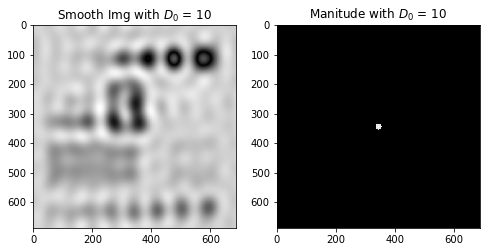

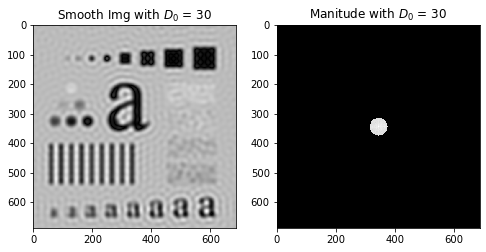

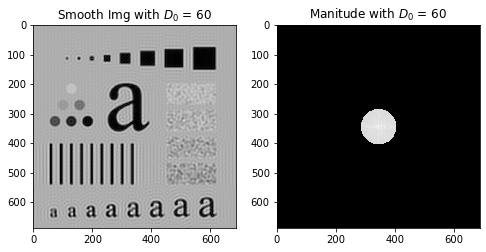

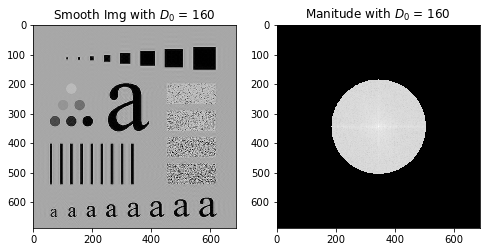

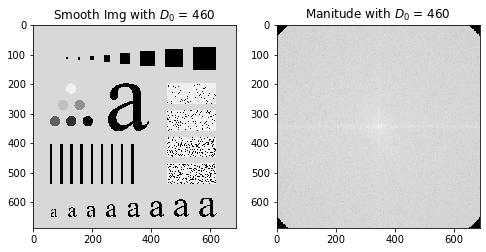

In [18]:
def getIdealFilterPassImg(input_img : np.array, filter_type : str , filter_d0, size = None):
    assert filter_type in ("lpf","hpf")
    # 内部进行填充 （mask大小与原图相等 进行2K-1的0填充）
    pad_img = getPaddingImg(input_img,input_img.shape,"corner")
    
    f_img = np.fft.fft2(input_img , s = size)
    shift_img = np.fft.fftshift(f_img)
    mask_shift_img = getIdealMask(f_img.shape,filter_d0,filter_type)
    new_shift_img = mask_shift_img*shift_img
    new_manitude_img = 20*np.log(np.abs(new_shift_img+eps))
    new_f_img = np.fft.ifftshift(new_shift_img)
    new_img = np.fft.ifft2(new_f_img)
    new_img = np.abs(new_img)
    
    # 内部进行裁剪
    new_img = cutOriginalImg(new_img, input_img.shape, "corner")
    return new_img,new_manitude_img,mask_shift_img

# 使用书上例子，cv库读取图像
original_img = cv2.imread('./DIP3E_Original_Images_CH04/Fig0441(a)(characters_test_pattern).tif',0)
print(original_img.shape)
# 设定截止半径
d_list = [10,30,60,160,460]

for d in d_list:
    smmoth_img,manitude_img,mask_img = getIdealFilterPassImg(original_img, "lpf" , d)
    showTwoImg(smmoth_img,manitude_img,f"Smooth Img with $D_0$ = {d}", f"Manitude with $D_0$ = {d}")

## 振铃现象

由上图可以看出随着阈值增大，频谱中保留功率的增大，图像细节逐渐明晰，模糊效果越来越差。这说明我们的滤波器是成功的（不过这里与课本P171图比较会清晰一些，不清楚原因）

另外，我们也可以很明显的发现**振铃现象**，间隙处原本统一的纹理由于模糊变得有明暗起伏。而随着被滤去的高频内容的数量的减少，图像的纹理变得越来越好，甚至我们仔细看第三幅图，也能发现振铃现象的纹理，课本是这么评价振铃现象和ILPF的。

> 这种振铃现象是理想滤波器的一种特性，从这个例子我们可以清楚地看到，理想低通滤波器并不是非常实用。然而，作为滤波概念发展的一部分，研究这种滤波器的特性非常有用。

## 振铃现象的一些见解

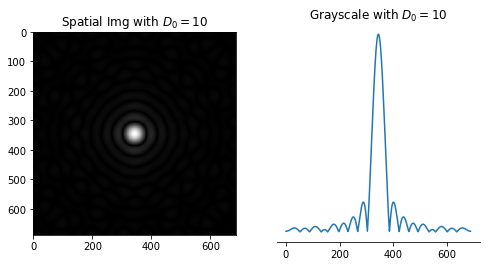

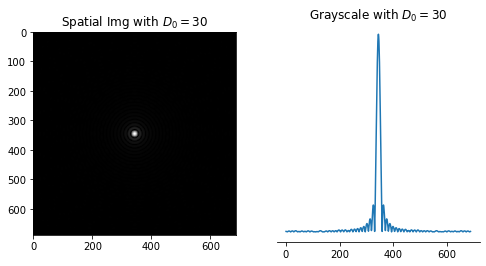

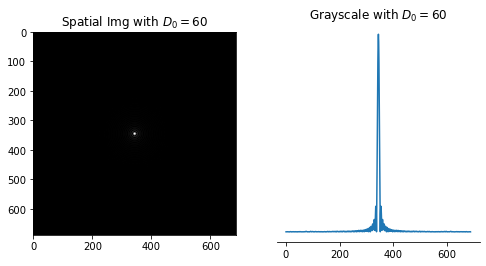

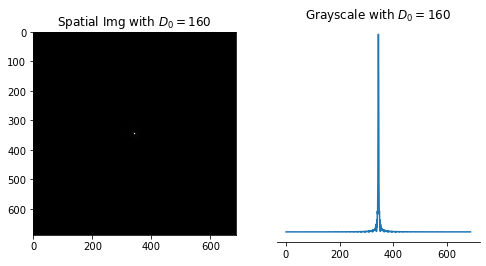

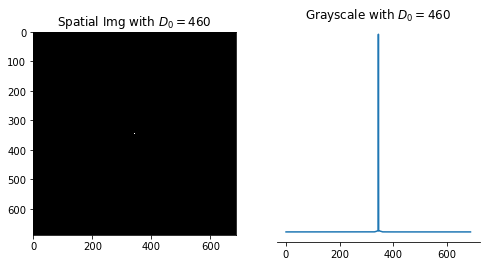

In [24]:
# 绘制空间域表示图和水平线灰度剖面图

for d in d_list:
    fre_mask=getIdealMask((688,688),d,"lpf")
    spa_mask=frequencyToSpatial(fre_mask)
    X = [i for i in range(spa_mask.shape[0])]
    Y = spa_mask[spa_mask.shape[0]//2]
    plt.figure(figsize=(8,4))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.set_title(f"Spatial Img with $D_0 = {d}$")
    ax2.set_title(f"Grayscale with $D_0 = {d}$")
    ax1.imshow(spa_mask,cmap = "gray")
    ax2.plot(X,Y)
    ax2.spines['left'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.set_yticks([])
    ax2.set_yticklabels([])

分别对应了上面的四个阈值，观察其滤波器的空间与表示，在$D_0$较小的时候有很明显的波动函数形状。

> ILPF的模糊和振铃特性可用卷积定理来解释。由于ILPF在频率域的剖面图类似于核装滤波器，因此可以预料相应空间滤波器具有sinc函数形状。空间域滤波可通过$h(x,y)$于图像卷积来实现。讲图像中的每个像素想象为一个离散冲击，它的强度与所在位置的灰度成正比。一个sinc函数与一个冲激卷积就是在冲激处复制这个sinc函数。**sinc函数的中心波瓣是引起模糊的主因，而外侧较小的波瓣是造成振铃的主要原因。sinc函数“展开度”与$H(u,v)$半径成反比，所以$D_0$越大，空间sinc函数就趋近于一个卷积时不会导致模糊但也不会产生振铃的冲激**